In [ ]:
# from google.colab import drive
# from google.colab import files
# drive.mount('/content/drive')

In [2]:
import threading
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from joblib import load, dump
import numpy as np
from timebudget import timebudget

np.random.seed(seed=42)
%matplotlib inline
# %config InlineBackend.figure_format='retina'

In [3]:
big_data_path = "../data/25m/ratings.csv"
small_data_path = "../data/100k/u.data"
figures_path = "../figures"
drive_path = "/content/drive/MyDrive/Applied_ML_at_Scale/Practical_1/data/"

In [4]:
blob_type = List[List[Tuple[int, float]]]
dict_type = Dict[str, int]
np_type = np.ndarray

In [5]:
class StorageManager:
    def __init__(self, path:str, filename:str):
        self.path = path
        self.filename = filename

    def save(self, data):
        dump(data, f'{self.path}{self.filename}.joblib')

    def load(self):
        return load(f'{self.path}{self.filename}.joblib')

In [6]:
def get_empty_blob(length:int) -> blob_type:
    blob:blob_type = []
    for i in range(length):
        blob.append([])

    return blob

In [7]:
class SparseMatrix:
    def __init__(self, data_path:str, sep:str=",", split_ratio=.2, n_iter:int=20, dims:int=3, tau:float=.01, lambd:float=.01, gamma:float=.01, mu:float=.0, save_figures=False):
        self.data_path:str = data_path
        self.sep:str = sep
        self.save_figures:bool = save_figures
        self.user_indexes:dict_type = dict()
        self.item_indexes:dict_type = dict()

        # Initializing model hyper parameters
        self.number_of_iterations: int = n_iter
        self.split_ratio : float = split_ratio
        self.latent_dims: int = dims
        self.tau_: float = tau
        self.lambda_: float = lambd
        self.gamma_: float = gamma
        self.mu = mu
        self.sigma = np.sqrt(5/np.sqrt(dims))

        file_lines = self.read_file()
        self.index_data(lines=file_lines)

        self.item_data_blob:blob_type = get_empty_blob(len(self.item_indexes))
        self.item_training_set:blob_type = get_empty_blob(len(self.item_indexes))
        self.item_testing_set:blob_type = get_empty_blob(len(self.item_indexes))

        self.user_data_blob:blob_type = get_empty_blob(len(self.user_indexes))
        self.user_training_set:blob_type = get_empty_blob(len(self.user_indexes))
        self.user_testing_set:blob_type = get_empty_blob(len(self.user_indexes))

        self.extract_all_file_ds(file_lines)
        self.extract_set_ds(file_lines, is_test=True)
        self.extract_set_ds(file_lines, is_test=False)

        # Initializing model parameters
        self.user_biases = np.zeros((len(self.user_indexes)))
        self.item_biases = np.zeros((len(self.item_indexes)))
        self.user_vector = np.random.normal(self.mu, self.sigma, size=(len(self.user_indexes), self.latent_dims))
        self.item_vector = np.random.normal(self.mu, self.sigma, size=(len(self.item_indexes), self.latent_dims))

        self.history = {"training_losses": [], "training_rmse": [], "testing_rmse": []}

        self.plot_all_file_ds()

    def read_file(self) -> List[str]:
        file = open(self.data_path,"r", encoding = "ISO-8859-1")
        lines = file.readlines()
        file.close()
        np.random.shuffle(lines)

        return lines

    @timebudget
    def index_data(self, lines: List[str]) -> None:
        for line in lines:
            content = line.split(self.sep)
            uid:str = content[0]
            iid:str = content[1]

            if uid not in self.user_indexes:
                self.user_indexes[uid] = len(self.user_indexes)

            if iid not in self.item_indexes:
                self.item_indexes[iid] = len(self.item_indexes)

    @timebudget
    def extract_set_ds(self, lines, is_test)->None:
        test_split_size = int(np.round(len(lines) * self.split_ratio))
        data_to_use = lines[-test_split_size:] if is_test else lines[:-test_split_size]

        for line in data_to_use:
            content = line.split(self.sep)
            uid:str = content[0]
            iid:str = content[1]
            rating = float(content[2])

            u_index = self.user_indexes[uid]
            i_index = self.item_indexes[iid]

            if is_test:
                self.user_testing_set[u_index].append((self.item_indexes[iid], rating))
                self.item_testing_set[i_index].append((self.user_indexes[uid],rating))
            else:
                self.user_training_set[u_index].append((self.item_indexes[iid], rating))
                self.item_training_set[i_index].append((self.user_indexes[uid],rating))

    @timebudget
    def extract_all_file_ds(self, lines: List[str]) -> None:
        for line in lines:
            content = line.split(self.sep)
            uid:str = content[0]
            iid:str = content[1]
            rating = float(content[2])

            u_index:int = self.user_indexes[uid]
            i_index:int = self.item_indexes[iid]

            self.user_data_blob[u_index].append((i_index, rating))
            self.item_data_blob[i_index].append((u_index, rating))


    def plot_all_file_ds(self) -> None:
        fig = plt.figure(figsize=(7, 5))
        u_degrees: List[int] = [len(ratings) for ratings in self.user_data_blob]
        u_frequencies: List[int] = [u_degrees.count(degree) for degree in u_degrees]
        plt.scatter(u_degrees, u_frequencies, c="b", marker="*", s=1)

        i_degrees: List[int] = [len(ratings) for ratings in self.item_data_blob]
        i_frequencies: List[int] = [i_degrees.count(degree) for degree in i_degrees]
        plt.scatter(i_degrees, i_frequencies, c="r", marker="s", s=1)

        plt.xscale('log')
        plt.yscale('log')
        plt.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.5)
        plt.xlabel("Rating Scale")
        plt.ylabel("Frequency of Ratings")
        plt.title("Frequency of Ratings")
        plt.legend(['Users', 'Items'])
        if self.save_figures:
            plt.savefig(f'{figures_path}/power_law.pdf')
            # files.download('power_law.pdf')

    def log_likelihood(self) -> float:
        user_data_blob:blob_type = self.user_training_set
        s:float = 0
        for m in range(len(self.user_biases)):
            for n, r in user_data_blob[m]:
                error = np.dot(self.user_vector[m], self.item_vector[n]) + self.user_biases[m] + self.item_biases[n]
                error = (r - error)**2
                s = s + error
        loss = - self.lambda_ * s / 2

        user_vector_term:float = 0
        for m in range(len(self.user_biases)):
            user_vector_term = user_vector_term + np.dot(self.user_vector[m], self.user_vector[m]) #.T

        user_vector_term:float = - user_vector_term * self.tau_ / 2
        user_biases_regularizer = - np.dot(self.user_biases, self.user_biases) * self.gamma_ / 2

        item_vector_term:float = 0
        for n in range(len(self.item_biases)):
            item_vector_term = item_vector_term + np.dot(self.item_vector[n], self.item_vector[n]) #.T

        item_vector_term:float = - item_vector_term * self.tau_ / 2
        item_biases_regularizer = - np.dot(self.item_biases, self.item_biases) * self.gamma_ / 2

        loss = loss + user_vector_term + item_vector_term + user_biases_regularizer + item_biases_regularizer
        return loss

    @timebudget
    def perform_als(self, dims=None, tau=None, lambd=None, gamma=None) -> None:
        if dims is not None:
            self.latent_dims = dims
            self.user_vector = np.random.normal(self.mu, self.sigma, size=(len(self.user_indexes), self.latent_dims))
            self.item_vector = np.random.normal(self.mu, self.sigma, size=(len(self.item_indexes), self.latent_dims))

        self.tau_ = self.tau_ if tau is None else tau
        self.lambda_ = self.lambda_ if lambd is None else lambd
        self.gamma_ = self.gamma_ if gamma is None else gamma
        self.history = {"training_losses": [], "training_rmse": [], "testing_rmse": []}

        # Getting data ready
        user_map: dict_type = self.user_indexes; u_data_blob: blob_type = self.user_training_set
        item_map: dict_type = self.item_indexes; i_data_blob: blob_type = self.item_training_set
        number_of_users: int = len(user_map)
        number_of_movies: int = len(item_map)

        # Initializing model hyper parameters
        Tau = self.tau_ * np.eye(self.latent_dims)

        for i in range(self.number_of_iterations):
            for m in range(number_of_users):
                bias = 0
                item_counter = 0
                for (n, r) in u_data_blob[m]:
                    bias += self.lambda_ * (r - self.item_biases[n] - np.dot(self.user_vector[m], self.item_vector[n]))
                    item_counter += 1
                bias = bias / (self.lambda_ * item_counter + self.gamma_)
                self.user_biases[m] = bias

            for n in range(number_of_movies):
                bias = 0
                user_counter = 0
                for (m, r) in i_data_blob[n]:
                    bias += self.lambda_ * (r - self.user_biases[m] - np.dot(self.user_vector[m], self.item_vector[n]))
                    user_counter += 1
                bias = bias / (self.lambda_ * user_counter + self.gamma_)
                self.item_biases[n] = bias

            for m in range(number_of_users):
                s = np.zeros((self.latent_dims, self.latent_dims))
                b = np.zeros(self.latent_dims)
                for n, r in u_data_blob[m]:
                    s = s + np.outer(self.item_vector[n], self.item_vector[n])
                    b = b + self.item_vector[n,:] * (r - self.user_biases[m] - self.item_biases[n])

                A = self.lambda_ * s + Tau
                b = self.lambda_ * b
                L = np.linalg.cholesky(A)
                um = np.linalg.inv(L.T) @ np.linalg.inv(L) @ b

                self.user_vector[m] = um

            for n in range(number_of_movies):
                s = np.zeros((self.latent_dims, self.latent_dims))
                b = np.zeros(self.latent_dims)
                for m, r in i_data_blob[n]:
                    s = s + np.outer(self.user_vector[m], self.user_vector[m])
                    b = b + self.user_vector[m] * (r - self.user_biases[m] - self.item_biases[n])

                A = self.lambda_ * s + Tau
                b = self.lambda_ * b
                L = np.linalg.cholesky(A)
                vn = np.linalg.inv(L.T) @ np.linalg.inv(L) @ b

                self.item_vector[n] = vn

            loss = self.log_likelihood()
            self.history["training_losses"].append(loss)

            training_cost = self.rmse(is_test=False)
            self.history["training_rmse"].append(training_cost)

            testing_cost = self.rmse(is_test=True)
            self.history["testing_rmse"].append(testing_cost)

            if (i +1) % 10 == 0 or i == 0:
                print(f"Iteration {i + 1} : Loss = {-loss:.4f} , Training cost = {training_cost:.4f}, Testing cost = {testing_cost:.4f}")

        self.plot_losses()
        self.plot_rmse()

    def plot_losses(self) -> None:
        fig, ax = plt.subplots(figsize=(9, 5))
        x = range(1, len(self.history["training_losses"]) + 1)

        ax.plot(x, [-k for k in self.history["training_losses"]], marker="d")
        ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.5)
        ax.set_xlabel("Iterations")
        ax.set_title("Losses during Training")
        ax.set_xticks(x)

        if self.save_figures:
            plt.savefig(f'{figures_path}/losses_l_{self.lambda_}_g_{self.gamma_}_t_{self.tau_}_K_{self.latent_dims}.pdf')

    def plot_rmse(self) -> None:
        fig, ax = plt.subplots(figsize=(9, 5))
        x = range(1, len(self.history["training_rmse"]) + 1)

        ax.plot(x, self.history["training_rmse"], marker="+")
        ax.plot(x, self.history["testing_rmse"], marker="4")
        ax.legend(["Training RMSE", "Testing RMSE"])
        ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.5)
        ax.set_title("Training cost vs Testing cost")
        ax.set_ylabel("RMSE")
        ax.set_xlabel("Iterations")
        ax.set_xticks(x)

        if self.save_figures:
            plt.savefig(f'{figures_path}/costs_l_{self.lambda_}_g_{self.gamma_}_t_{self.tau_}_K_{self.latent_dims}.pdf')


    def get_predictions(self, is_test) -> (List[float], List[float]):
        user_map = self.user_indexes; u_data_blob = self.user_testing_set if is_test else self.user_training_set
        number_of_users = len(user_map)
        predictions:List[float] = []
        targets:List[float] = []
        for m in range(number_of_users):
            for n, r in u_data_blob[m]:
                pred = np.dot(self.user_vector[m], self.item_vector[n]) + self.user_biases[m] + self.item_biases[n]
                targets.append(r)
                predictions.append(pred)

        return targets, predictions

    def rmse(self, is_test) -> float:
        targets, predictions = self.get_predictions(is_test)
        mse = np.square(np.subtract(targets, predictions)).mean()
        return np.sqrt(mse)


index_data took 49.66ms
extract_all_file_ds took 144.81ms
extract_set_ds took 23.85ms
extract_set_ds took 95.30ms


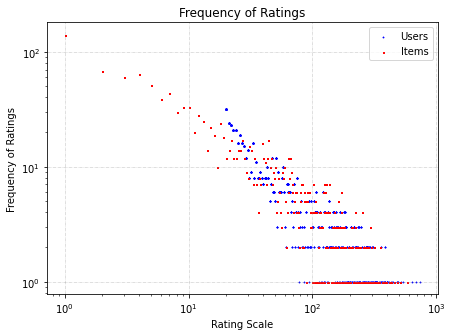

In [8]:
test = SparseMatrix(
    data_path=small_data_path,
    sep="\t",
    split_ratio = .2,
    n_iter=30,
    dims=5,
    tau=.01,
    lambd=.01,
    gamma=.01,
    mu=.0,
    save_figures=True,
)

In [ ]:
# test = SparseMatrix(data_path=big_data_path, sep:str=",", test_samples_per_user = 3, test_samples_per_item = 3, n_iter:int=20, dims:int=3, tau:float=0.01, lambd:float=0.01, gamma:float=0.01, mu:float=0.0)

In [ ]:
# with Parallel(n_jobs=6, backend="loky", verbose=30) as parallel:
#     delayed_func = delayed(lambda x: x.perform_ALS)(test)
#     output = parallel([delayed_func])

Iteration 1 : Loss = 511.7806 , Training cost = 1.0203, Testing cost = 1.1040
Iteration 10 : Loss = 318.0493 , Training cost = 0.8078, Testing cost = 0.9413
Iteration 20 : Loss = 305.4222 , Training cost = 0.8001, Testing cost = 0.9349
Iteration 30 : Loss = 300.3331 , Training cost = 0.7983, Testing cost = 0.9368
perform_als took 63.793sec


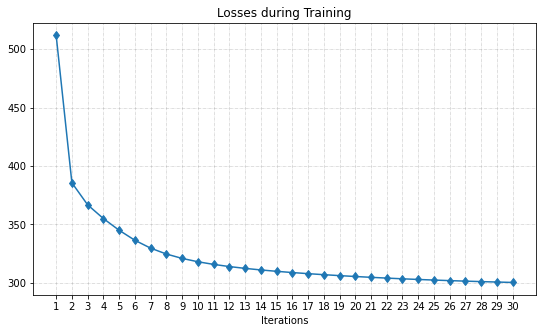

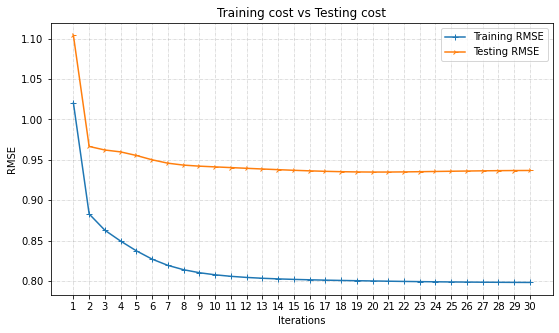

In [9]:
test.perform_als(dims=3, tau=0.01, lambd=0.01, gamma=0.01)

Iteration 1 : Loss = 572.6826 , Training cost = 1.0936, Testing cost = 1.1938
Iteration 10 : Loss = 274.7601 , Training cost = 0.7549, Testing cost = 0.9594
Iteration 20 : Loss = 269.8203 , Training cost = 0.7491, Testing cost = 0.9636
Iteration 30 : Loss = 268.2852 , Training cost = 0.7476, Testing cost = 0.9636
perform_als took 61.071sec


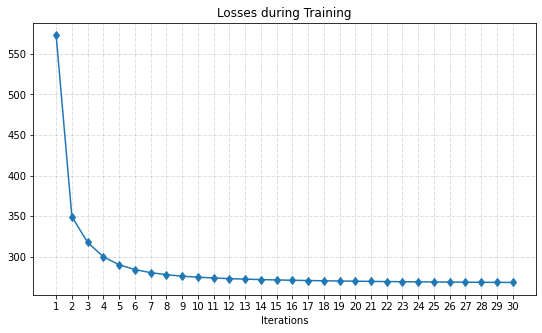

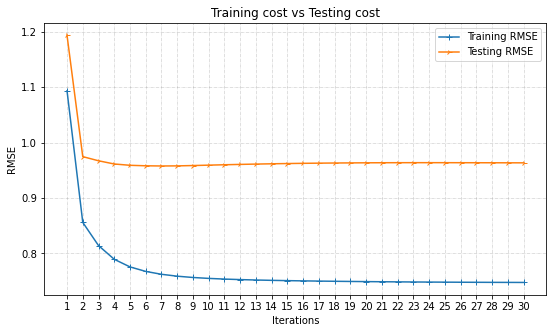

In [10]:
test.perform_als(dims=5, tau=0.01, lambd=0.01, gamma=0.01)

Iteration 10 : Loss = 229.7877 , Training cost = 0.6643, Testing cost = 1.0317
Iteration 20 : Loss = 221.3965 , Training cost = 0.6497, Testing cost = 1.0441
Iteration 30 : Loss = 219.3100 , Training cost = 0.6457, Testing cost = 1.0510
perform_als took 61.518sec


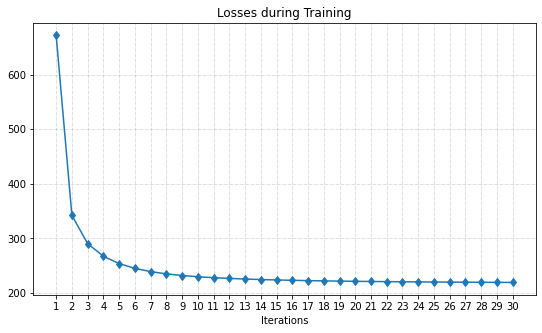

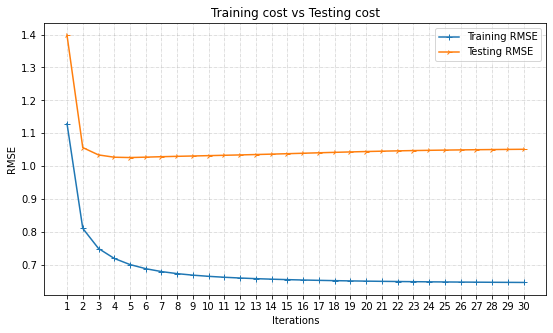

In [17]:
test.perform_als(dims=10, tau=0.01, lambd=0.01, gamma=0.01)

Iteration 10 : Loss = 202.5175 , Training cost = 0.5929, Testing cost = 1.0856
Iteration 20 : Loss = 187.5934 , Training cost = 0.5687, Testing cost = 1.1158
Iteration 30 : Loss = 183.4641 , Training cost = 0.5597, Testing cost = 1.1344
perform_als took 63.669sec


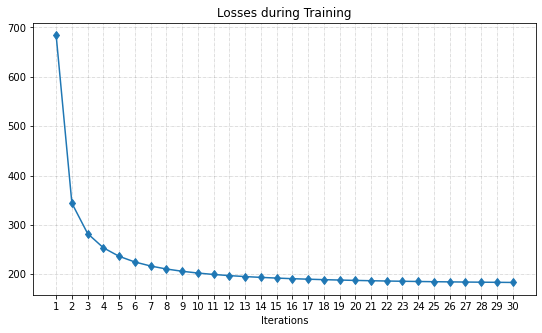

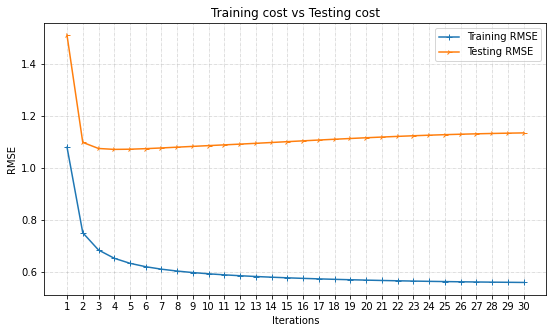

In [18]:
test.perform_als(dims=15, tau=0.01, lambd=0.01, gamma=0.01)

Iteration 10 : Loss = 177.8865 , Training cost = 0.5231, Testing cost = 1.1617
Iteration 20 : Loss = 161.2363 , Training cost = 0.4964, Testing cost = 1.1783
Iteration 30 : Loss = 157.1412 , Training cost = 0.4869, Testing cost = 1.1898
perform_als took 66.107sec


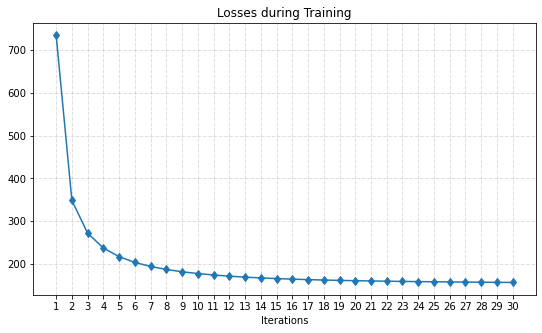

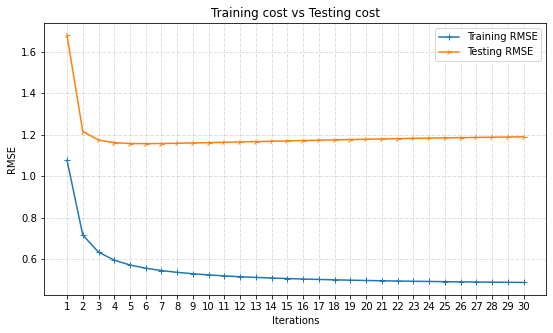

In [19]:
test.perform_als(dims=20, tau=0.01, lambd=0.01, gamma=0.01)

Iteration 10 : Loss = 145.5564 , Training cost = 0.4065, Testing cost = 1.2437
Iteration 20 : Loss = 125.4098 , Training cost = 0.3756, Testing cost = 1.2540
Iteration 30 : Loss = 120.3184 , Training cost = 0.3631, Testing cost = 1.2601
perform_als took 74.771sec


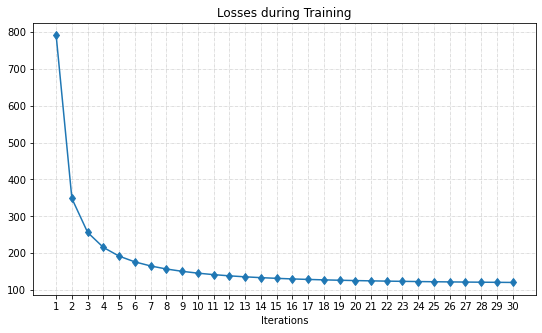

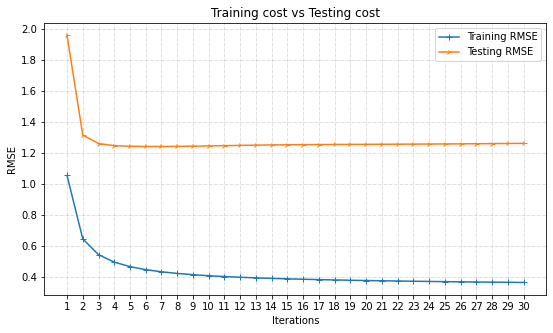

In [20]:
test.perform_als(dims=30, tau=0.01, lambd=0.01, gamma=0.01)

Iteration 10 : Loss = 129.7886 , Training cost = 0.2468, Testing cost = 1.3195
Iteration 20 : Loss = 95.7228 , Training cost = 0.2061, Testing cost = 1.3047
Iteration 30 : Loss = 87.2105 , Training cost = 0.1920, Testing cost = 1.2992
perform_als took 84.572sec


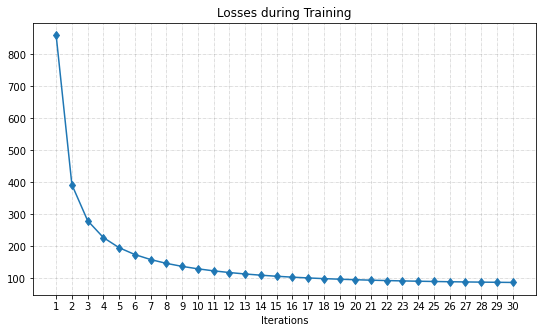

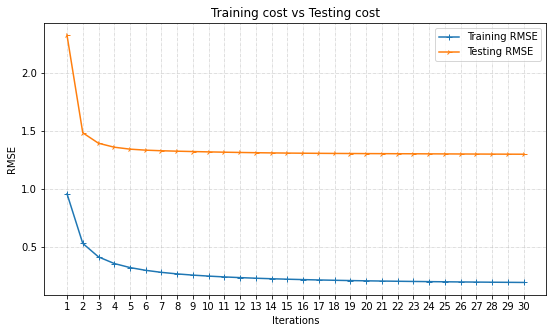

In [21]:
test.perform_als(dims=50, tau=0.01, lambd=0.01, gamma=0.01)

Iteration 10 : Loss = 155.1272 , Training cost = 0.1190, Testing cost = 1.2800
Iteration 20 : Loss = 102.0201 , Training cost = 0.0942, Testing cost = 1.1841
Iteration 30 : Loss = 83.2777 , Training cost = 0.0866, Testing cost = 1.1331
perform_als took 175.067sec


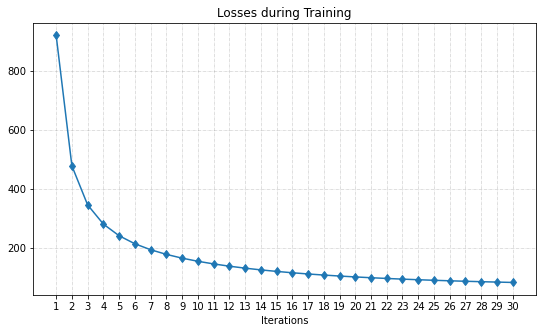

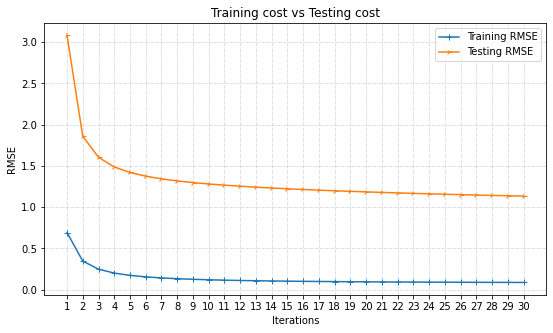

In [22]:
test.perform_als(dims=100, tau=0.01, lambd=0.01, gamma=0.01)

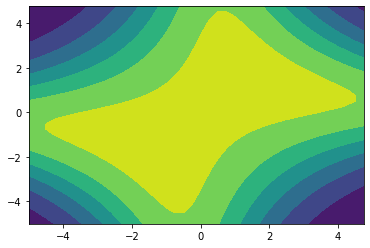

In [11]:
def plot_loss_contourf(r, tau_, lambda_):
    fig, ax = plt.subplots()
    u = np.arange(-5, 5, 0.25)
    v = np.arange(-5, 5, 0.25)
    U, V = np.meshgrid(u, v)

    P = np.exp(-0.5 * lambda_*(r - U * V)**2) * np.exp(-0.5 * tau_ * U * U) * np.exp(-0.5 * tau_ * V * V)
    ax.contourf(U, V, P)


# fig, ax = plt.subplots(nrows=1, ncols=5)
# for tau in np.arange(0.1, 0.5, 0.1):
plot_loss_contourf(3, 0.01, 0.01)